In [3]:
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scirpy as ir
import numpy as np
import pathlib
import muon as mu
from muon import prot as pt
import os
import numpy as np
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import celltypist
from celltypist import models
overload = False
if overload == True:
    output_dir='figures/overload'
else:
    output_dir = "figures/no_overload"

pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg"]
sc.settings.figdir = output_dir
sc.set_figure_params(dpi_save = 300)
sc.set_figure_params(format = 'png')
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None


donor = 'TBD6'
data = 'data/10X'
#samples = ['BM', 'PBMC', 'LN', 'SPL', 'BM_Overload', 'PBMC_Overload', 'LN_Overload', 'SPL_Overload']
samples = ['LN', 'SPL', 'PBMC', 'BM']
prots = []
tenX_output = 'filtered'

def load_data(samplenames, data, donor, overload):
    """samplename is a list of samplenames / tissue names, 
    data is where the data were downloaded
    donor is the name of the donor
    all of these info are used to create the file path
    """
    
    for sample in samples:
        if tenX_output == 'raw':
            datapath = '{}/{}_{}/outs/multi/count/raw_feature_bc_matrix/'.format(data, donor, sample)
            print(datapath)
            prot = mu.read_10x_mtx(datapath)
            prots.append(prot)
            prot['prot'].obs['tissue'] = sample
        if tenX_output == 'filtered':
            datapath = '{}/{}_{}/outs/per_sample_outs/{}_{}/count/sample_feature_bc_matrix/'.format(data, donor, sample, donor ,sample)
            print(datapath)
            prot = mu.read_10x_mtx(datapath)
            prots.append(prot)
            prot['rna'].obs['tissue'] = sample
 
    adatas = []
    for prot in prots:
        adata = prot['rna']
        adatas.append(adata)
    if overload == True:
        analysis = "with_overload"
    else:
        analysis = "without_overload"
    if overload:
    # hard coded number of samples right now
        adata = adatas[0].concatenate(adatas[1], adatas[2], adatas[3], adatas[4], adatas[5], adatas[6], adatas[7])
    else:
        adata = adatas[0].concatenate(adatas[1], adatas[2], adatas[3])
    return adata
    
def perform_qc(adata):    
    # calculate qc metrics
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    adata = adata[:,~adata.var.index.str.contains('HSP|DNAJ')]
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)
    sc.pl.highest_expr_genes(adata,save='prefilter')
    # plot qc metrics
    sc.pl.violin(adata, ['n_genes_by_counts', 'log1p_total_counts', 'total_counts'], stripplot=False, multi_panel=True, save='prefilter')
    # cell filter
    sc.pp.filter_cells(adata, min_counts=800)
    sc.pp.filter_cells(adata, max_counts=40000)
    adata = adata[adata.obs['pct_counts_mt'] < 10]
    # plot results of filtering
    sc.pl.violin(adata, ['n_genes_by_counts', 'log1p_total_counts', 'total_counts'], stripplot=False, multi_panel=True, save='postfilter')
    sc.pl.violin(adata, ['n_genes_by_counts', 'log1p_total_counts', 'total_counts'], stripplot=False, multi_panel=True, rotation = 90, groupby='tissue', save='postfilter_tissue')

    sc.pl.highest_expr_genes(adata, save='postfilter')
    return adata






# create concatenated adata object
adata = load_data(samplenames=samples, data = data, donor=donor, overload=False)
# write for later use
adata.write_h5ad('data/full_object.h5ad')

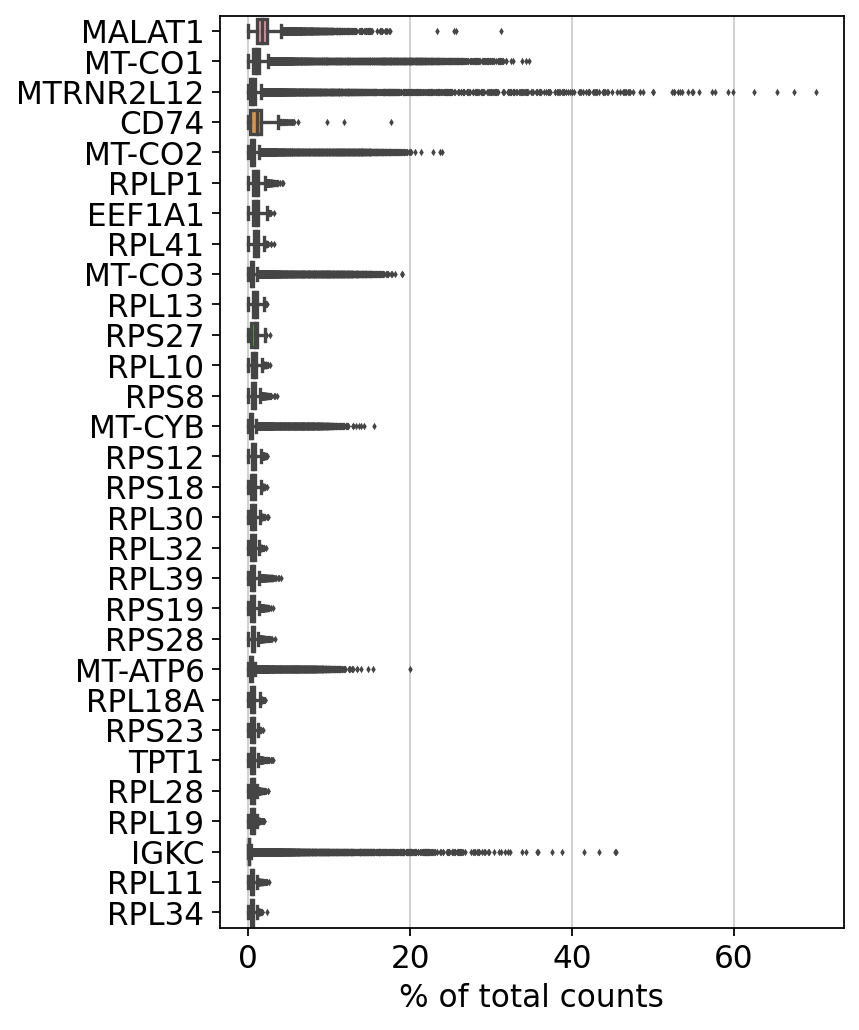

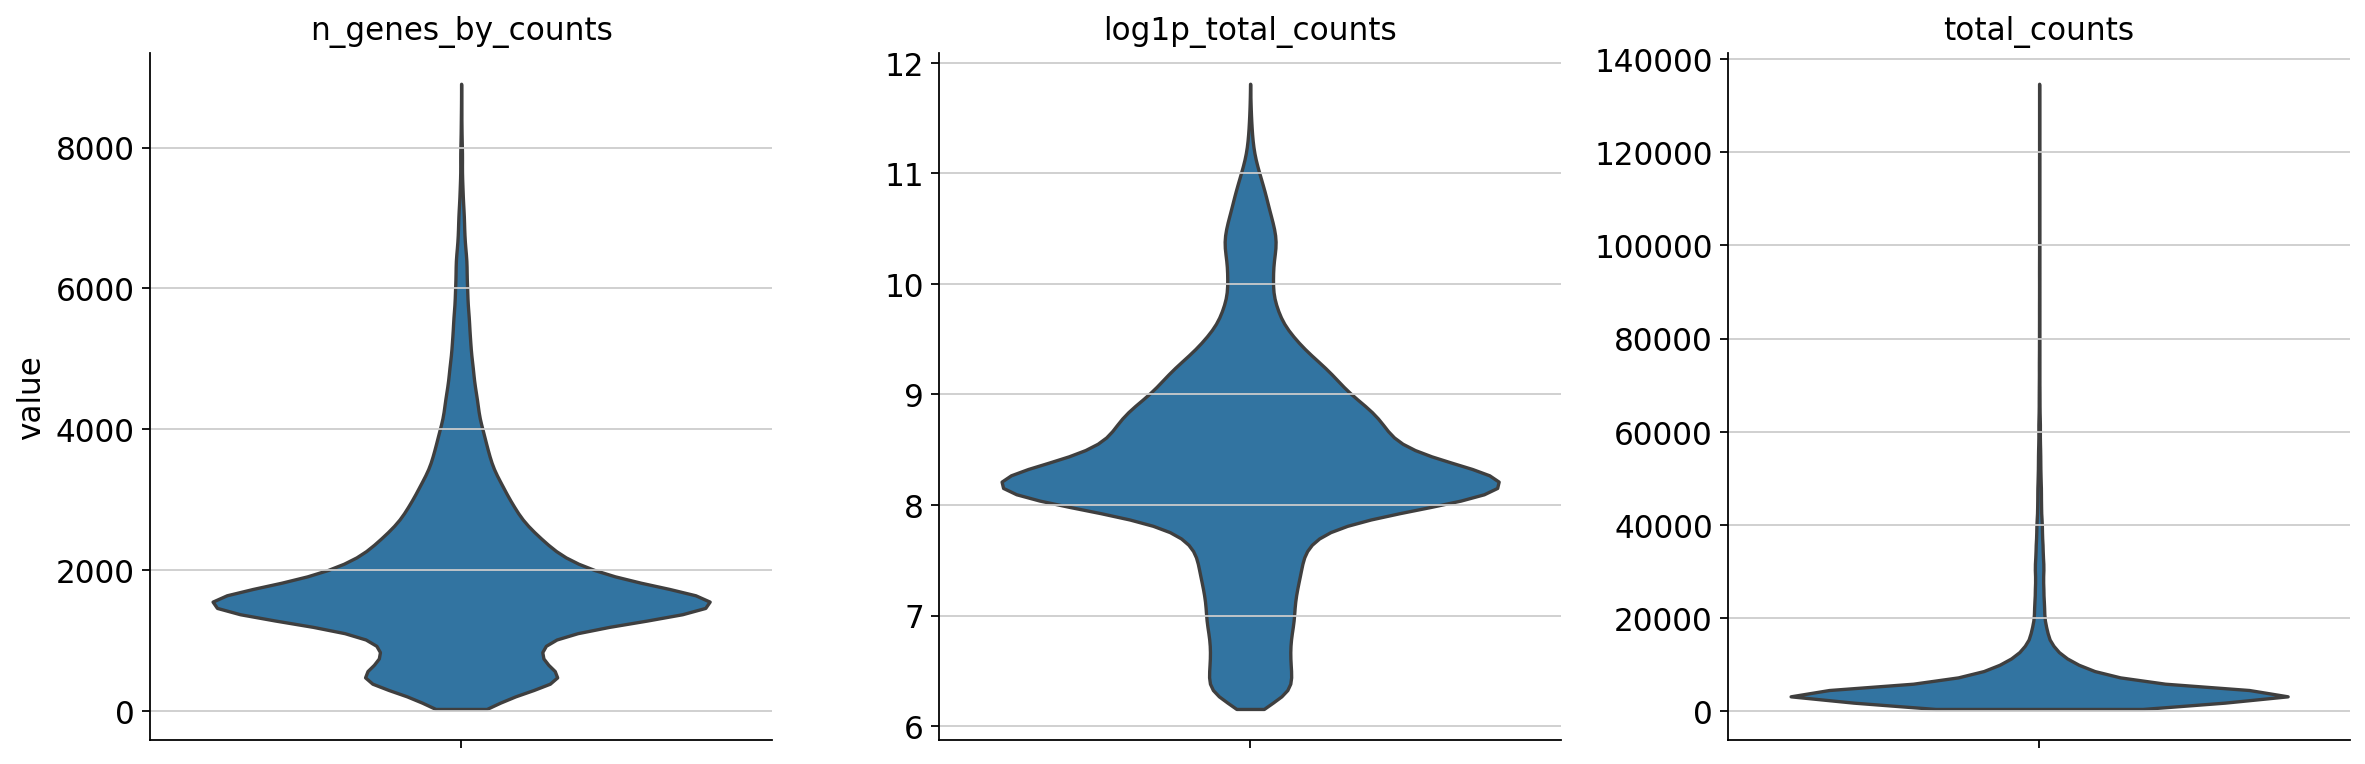

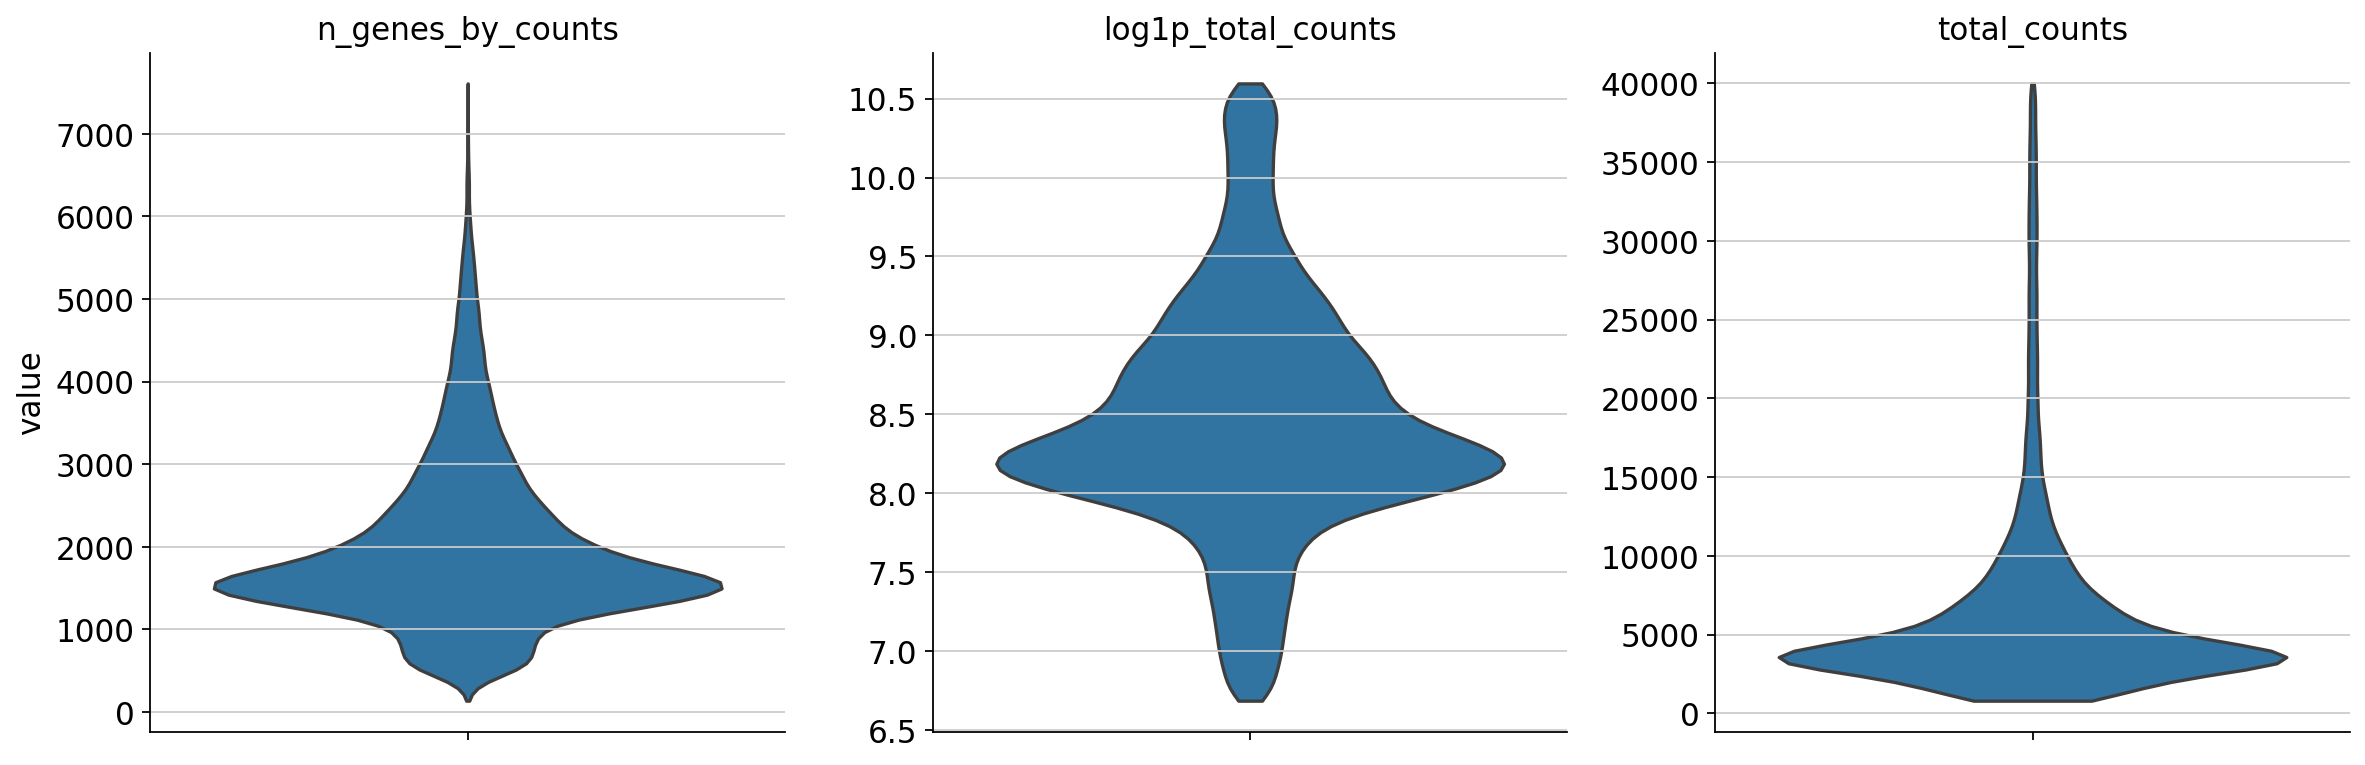

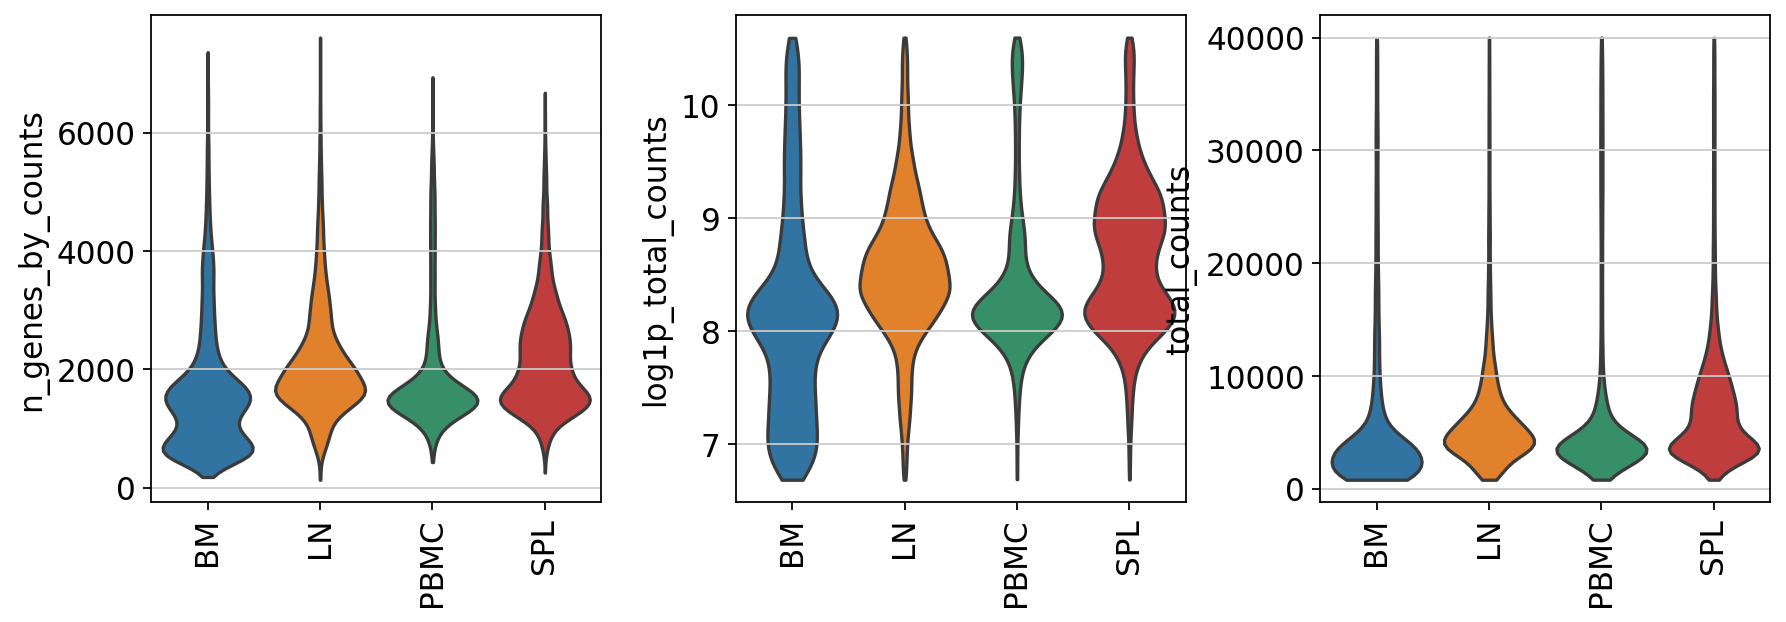

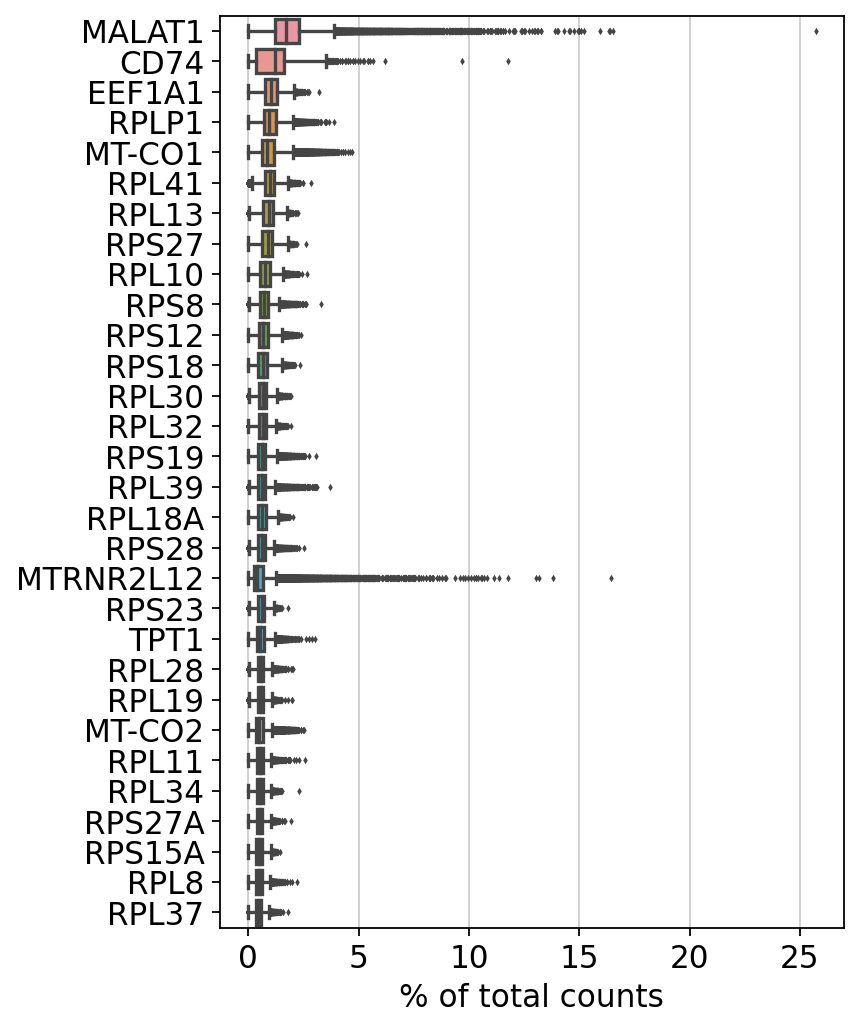

In [6]:
adata = sc.read_h5ad('../../data/processed_h5ad/full_object.h5ad')
adata = perform_qc(adata)


In [8]:
def tissue_colors():
    
    tissue_color_dict = {
             'PBMC': '#d6616b',
             'BM': '#cedb9c',
             'LN': '#8c6d31',
             'SPL': '#393b79'}
          
    
    return tissue_color_dict


In [9]:
rna = adata

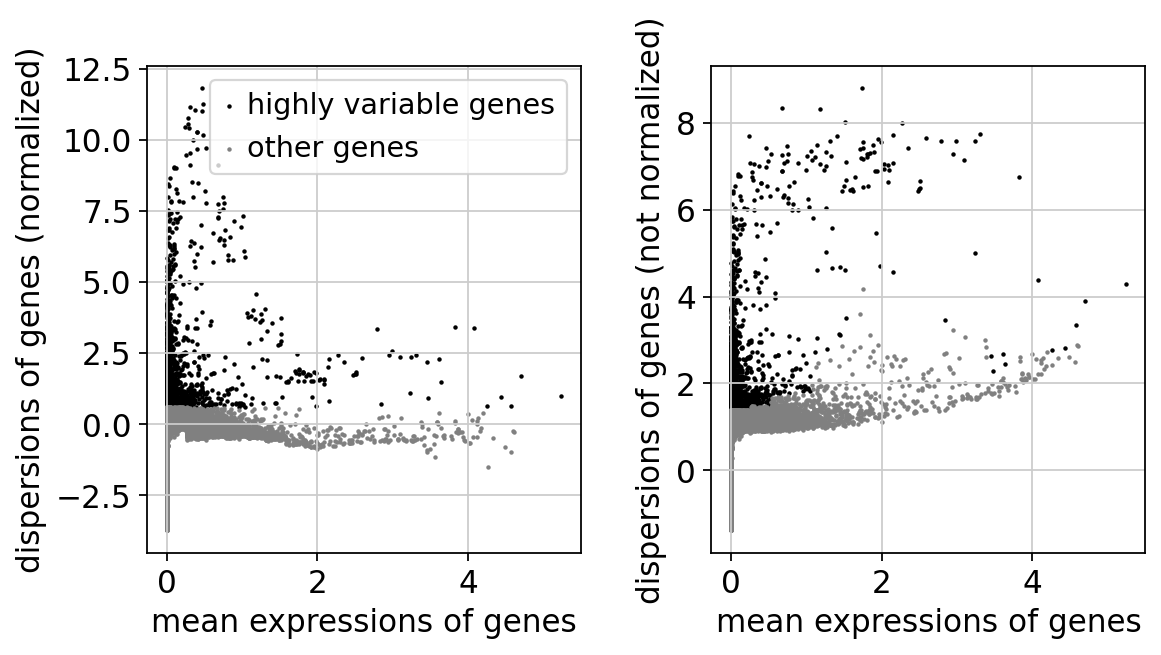

In [10]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna, base = 2)
sc.pp.highly_variable_genes(rna, n_top_genes=4000)
sc.pl.highly_variable_genes(rna)
rna.raw = rna
sc.pp.scale(rna, max_value = 10)

In [13]:
rna.var.loc[rna.var.index.str.contains("IGHV|IGLV|IGKV"), 'highly_variable'] = False

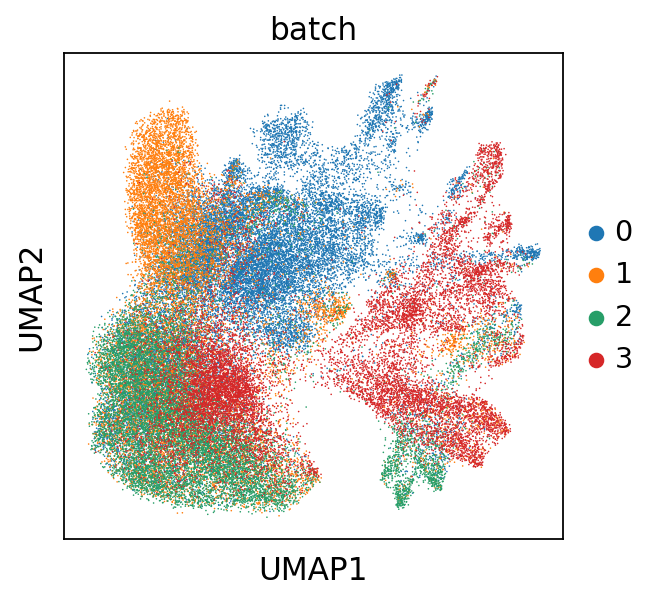

In [14]:
def recluster(adata, batch_correct, batch_key):
    sc.pp.pca(adata)
    if batch_correct == True:
        sce.pp.bbknn(adata, batch_key=batch_key)
    else:
        sc.pp.neighbors(adata, n_neighbors=20)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.2)
    sc.pl.umap(adata, color = 'batch')
    return adata
rna = recluster(rna, batch_correct=True, batch_key = 'tissue')

# Label the cells with celltypist

In [15]:

#Download all the available models.
#models.download_models()
#Update all models by re-downloading the latest versions if you think they may be outdated.
#models.download_models(force_update = True)

#Provide the input as an `AnnData`.
#predictions = celltypist.annotate('data/bcells.h5ad', model = 'Immune_All_Low.pkl', majority_voting=True)
#Alternatively, the input can be specified as an `AnnData` already loaded in memory.
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting=True)
# Celltypist Annotations to bcells object
adata.obs['celltypist'] = predictions.predicted_labels.majority_voting

👀 Detected scaled expression in the input data, will try the `.raw` attribute
🔬 Input data has 58157 cells and 36518 genes
🔗 Matching reference genes in the model
🧬 6117 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


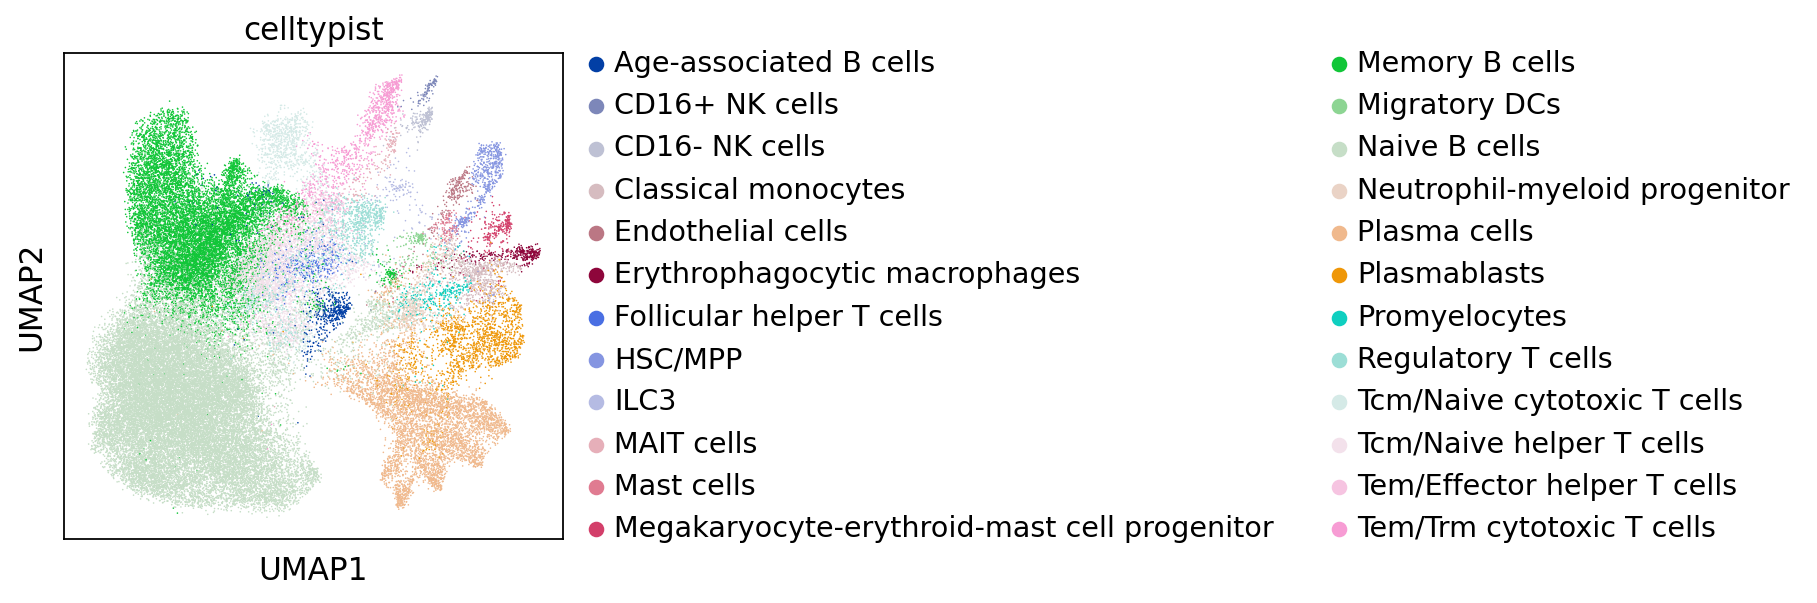

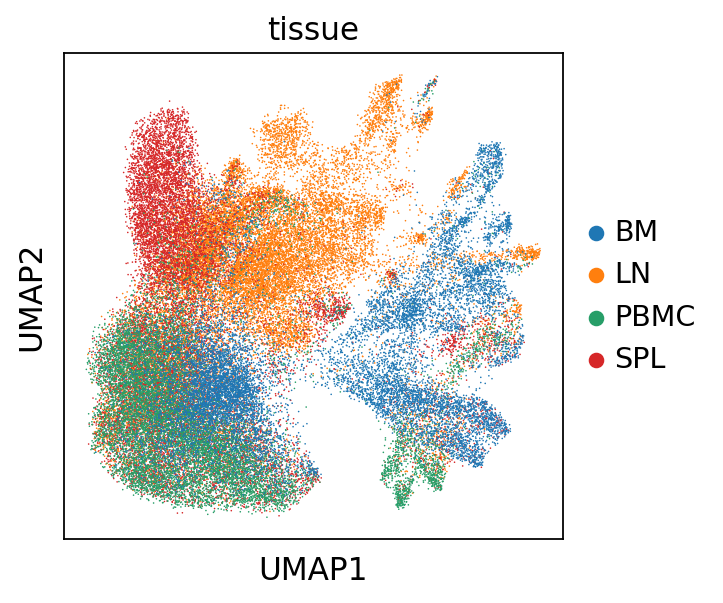

In [16]:
sc.pl.umap(adata, color = 'celltypist')
sc.pl.umap(adata, color = 'tissue')

# cell proportions by tissue

Text(0, 0.5, 'sample_id')

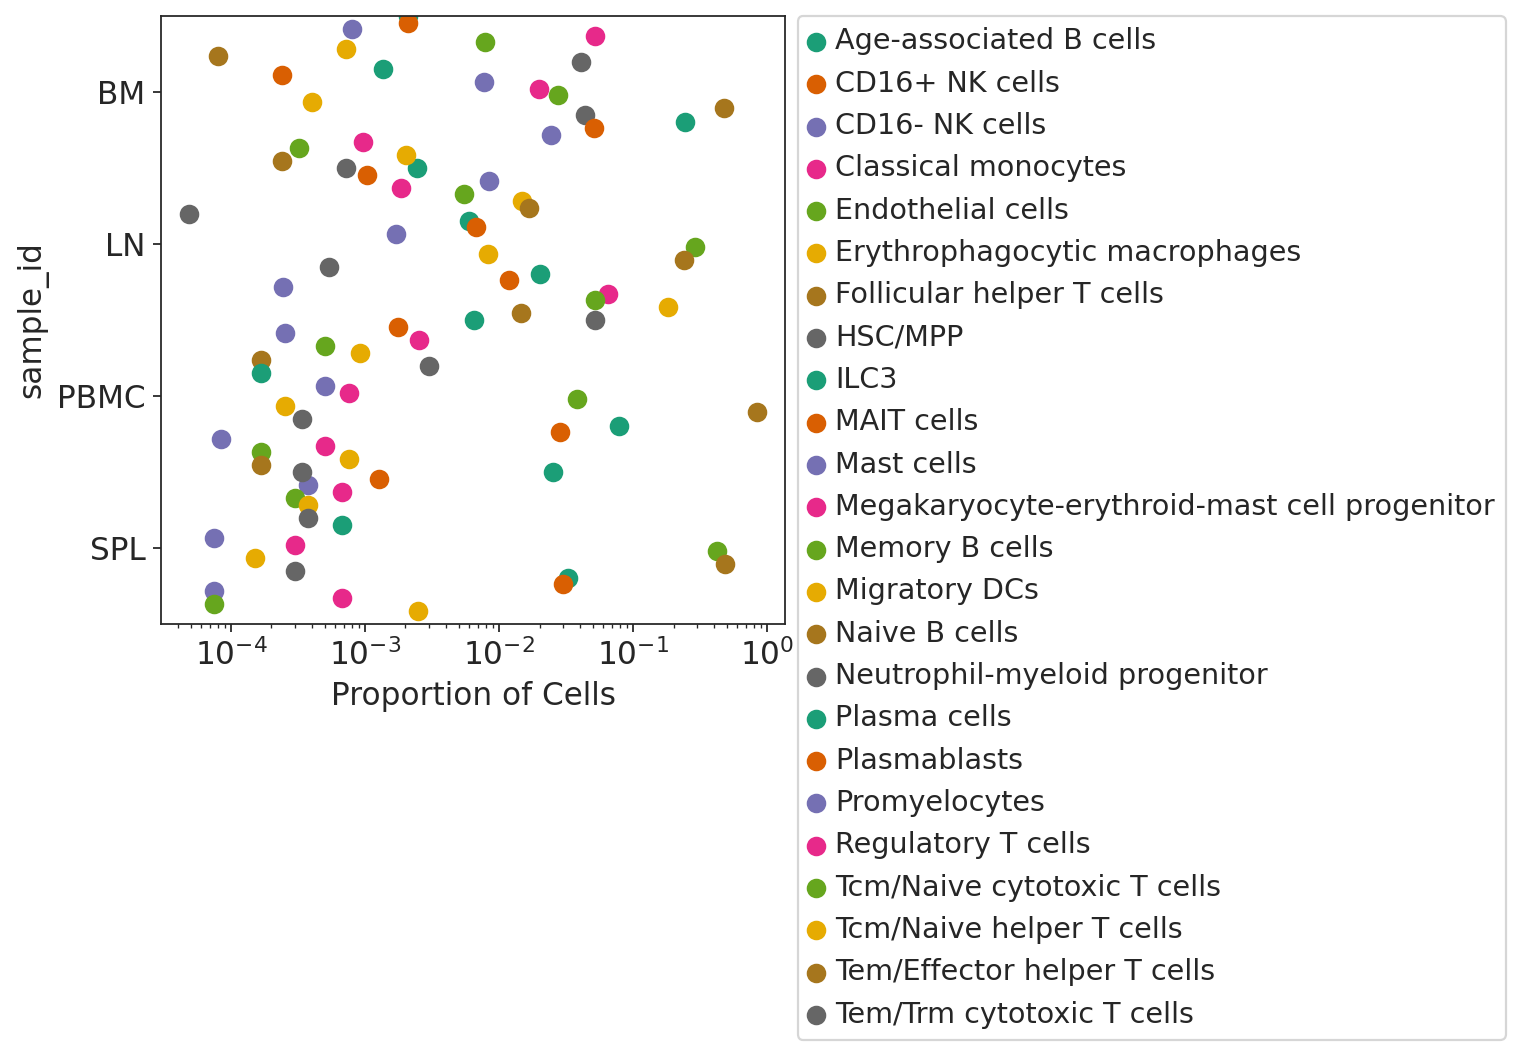

In [17]:
group = "tissue"
label = "celltypist"
color = label
data = pd.DataFrame(rna.obs.groupby([group])[label].value_counts(normalize=True))
data.columns = ["dummy"]
data.reset_index(inplace=True)
data.columns = ["sample_id", "celltype", "proportion"]
sns.axes_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.pointplot(
    y="sample_id",
    x="proportion",
    hue="celltype",
    data=data,join = False, dodge=1, palette='Dark2')

plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")

In [18]:
sub_data = data[data.proportion > 0.03]

In [19]:
sub_data.celltype = sub_data.celltype.cat.remove_unused_categories()

/tmp/ipykernel_5211/3588612479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data.celltype = sub_data.celltype.cat.remove_unused_categories()


# cell proportions by tissue

Text(0, 0.5, 'sample_id')

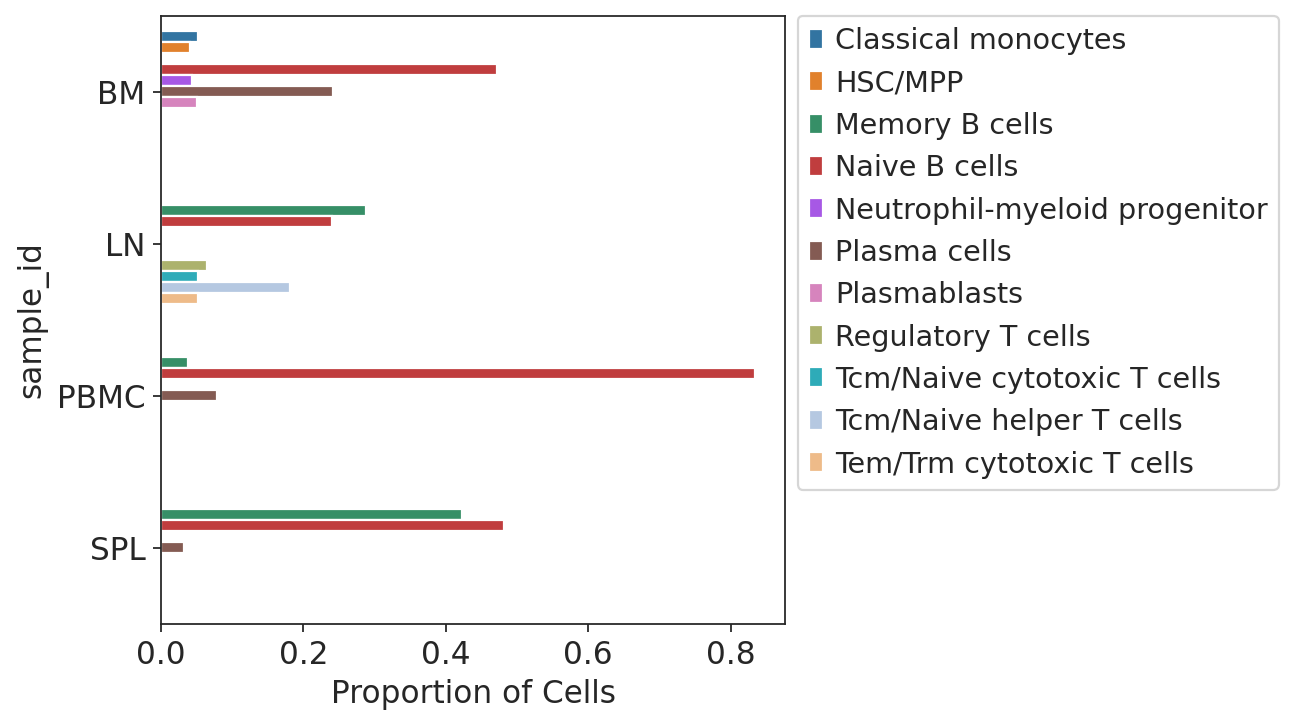

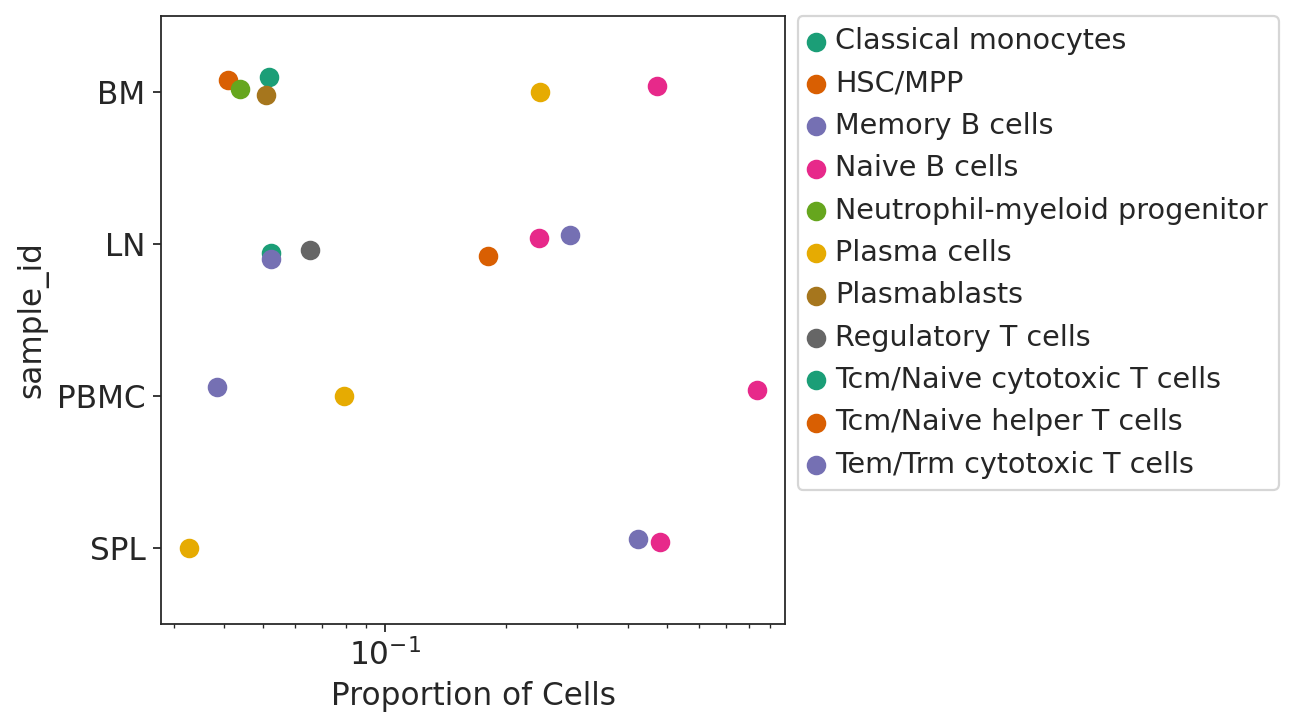

In [20]:
sns.axes_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.barplot(
    y="sample_id",
    x="proportion",
    hue="celltype",
    data=sub_data,)

#plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")


fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.pointplot(
    y="sample_id",
    x="proportion",
    hue="celltype",
    data=sub_data,join = False, dodge=0.2, palette='Dark2')

plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xlabel("Proportion of Cells")
plt.ylabel("sample_id")


In [46]:
# proportion of age-associated B cells within the B cell subset
sub_data = data[data.celltypist.str.contains('B cell|Plasma')].groupby('tissue').celltypist.value_counts(normalize = True).unstack()

<AxesSubplot:xlabel='tissue', ylabel='Age-associated B cells'>

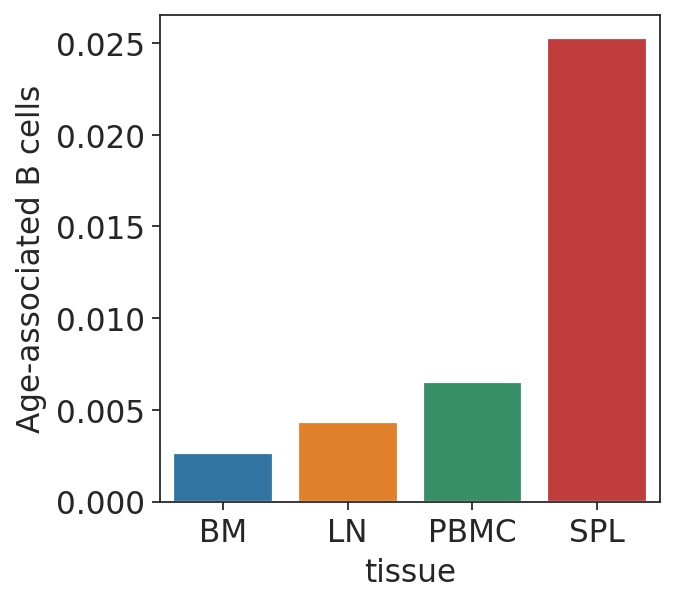

In [52]:
## Age associated B-cells:
adata = rna
group = "tissue"
data = adata.obs
sub_adata = data[data.celltypist == 'Age-associated B cells']
#
fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.barplot(x = sub_data.index, y = sub_data['Age-associated B cells'])
plt.xlabel("Number of Age-Associated B cells")

save_figure(fig, "number_of_age_associated_b_cells_{}".format(group))


In [42]:
sub_adata = adata[adata.obs.celltypist.str.contains('Age-associated')]

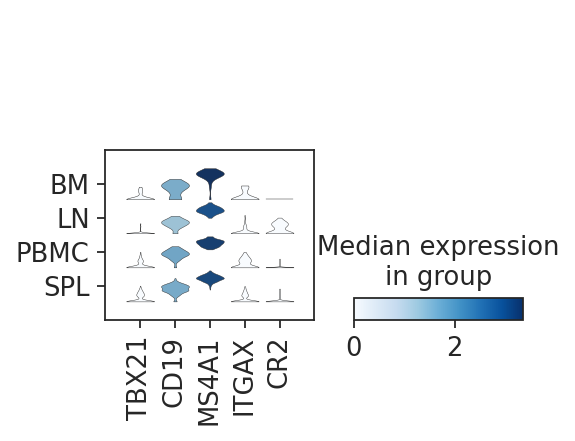

In [45]:
sc.pl.stacked_violin(sub_adata, var_names=['TBX21', 'CD19', 'MS4A1', 'ITGAX', 'CR2'], groupby='tissue')

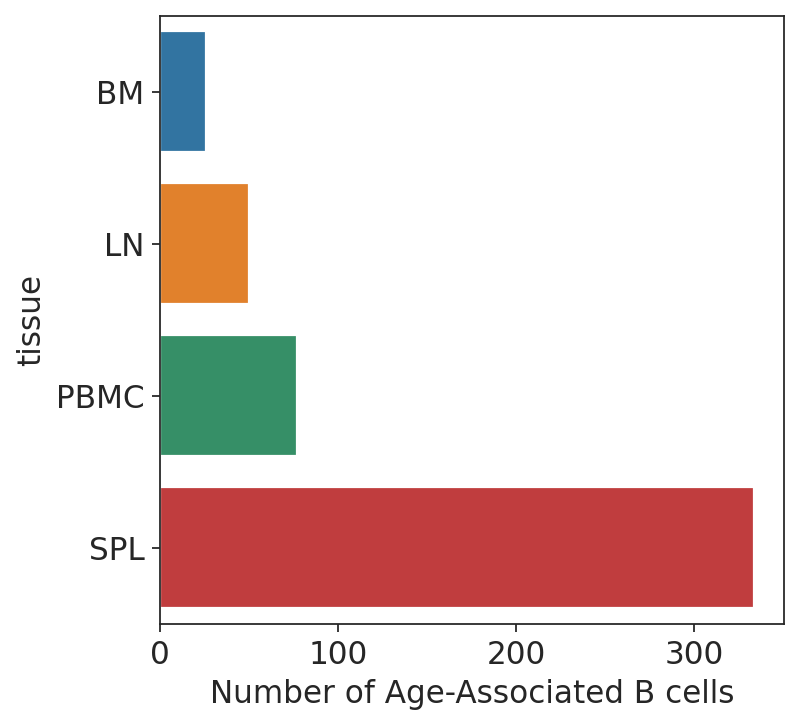

In [34]:
## Age associated B-cells:
adata = rna
group = "tissue"
data = adata.obs
sub_adata = data[data.celltypist == 'Age-associated B cells']
#
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.countplot(y=group, data=sub_adata)


plt.xlabel("Number of Age-Associated B cells")

save_figure(fig, "number_of_age_associated_b_cells_{}".format(group))

# cells per tissue

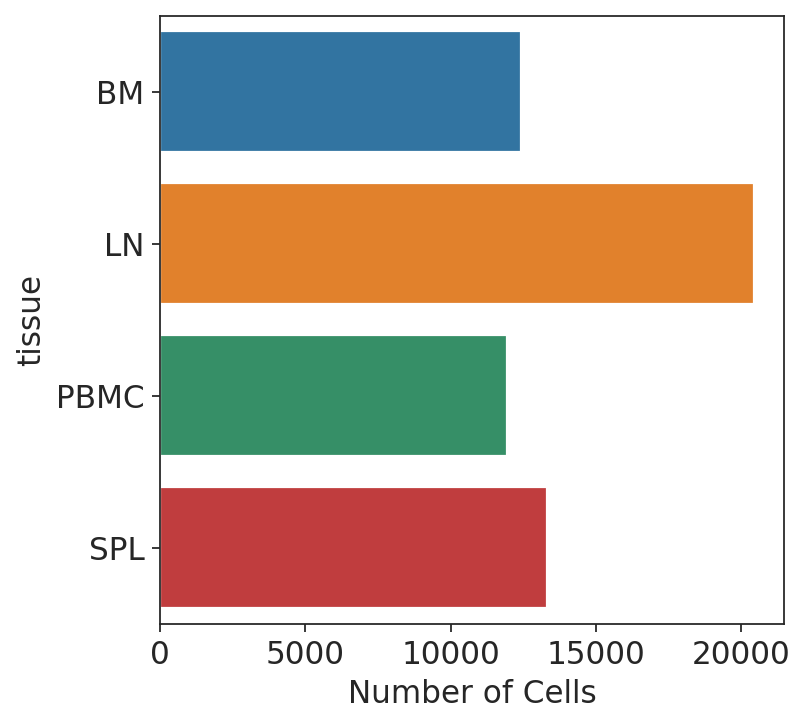

In [21]:
adata = rna
group = "tissue"
data = adata.obs

fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.countplot(y=group, data=data)


plt.xlabel("Number of Cells")

save_figure(fig, "number_of_cells_{}".format(group))

# differential expression between same cell type, different tissue

In [23]:
cell_type = 'Plasma cells'
label = 'tissue'
cell_label = 'celltypist'
_sub_adata = adata[adata.obs[cell_label] == cell_type]
print("{} {} in the dataset".format(_sub_adata.obs.shape[0], cell_type))

# subset to tissues with more than 10 cells detected in this class
# for reasonable differential epxression comparison
_df = pd.DataFrame(_sub_adata.obs.groupby(label)[cell_label].value_counts() > 10)
_tissues = _df[_df[cell_label] == True].unstack().index.to_list()
_sub_adata = _sub_adata[_sub_adata.obs.tissue.isin(_tissues)]
print("{} {} in the dataset {}".format(_sub_adata.obs.shape[0], cell_type, "after filtering out low abundance tissues"))

4799 Plasma cells in the dataset
4799 Plasma cells in the dataset after filtering out low abundance tissues


In [24]:
print("performing differential expression analysis")
min_fold_change = 2
# uses t-test for speed, but wilcoxon is the more appropriate test I'm told
sc.tl.rank_genes_groups(_sub_adata, groupby=label)
sc.tl.filter_rank_genes_groups(_sub_adata, min_fold_change=min_fold_change)
print("filtered genes by min fold change {}".format(min_fold_change))

performing differential expression analysis
filtered genes by min fold change 2


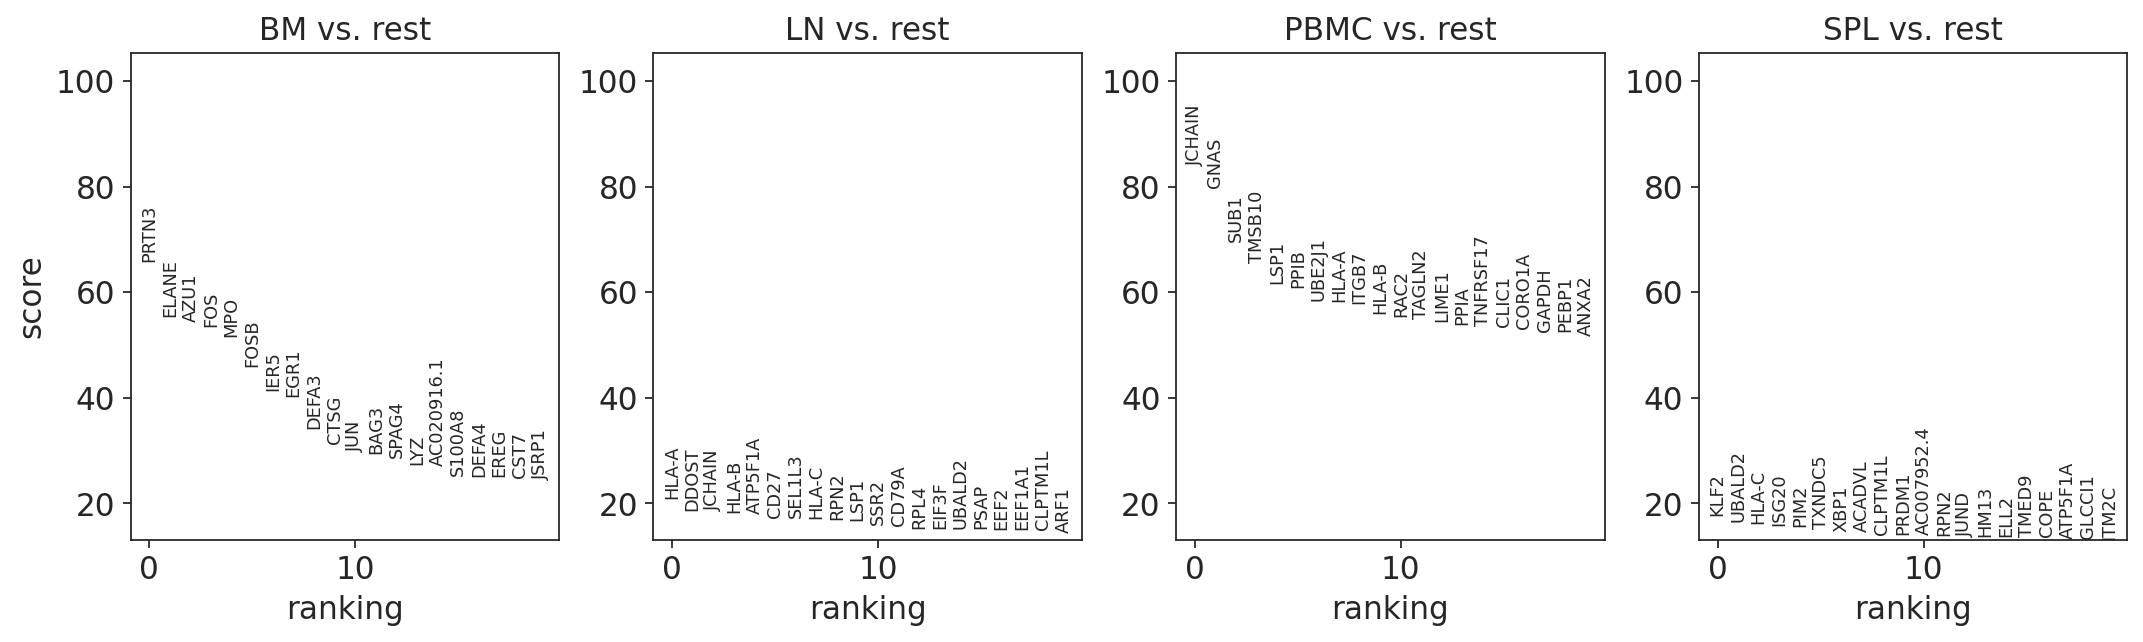

In [25]:
sc.pl.rank_genes_groups(_sub_adata)

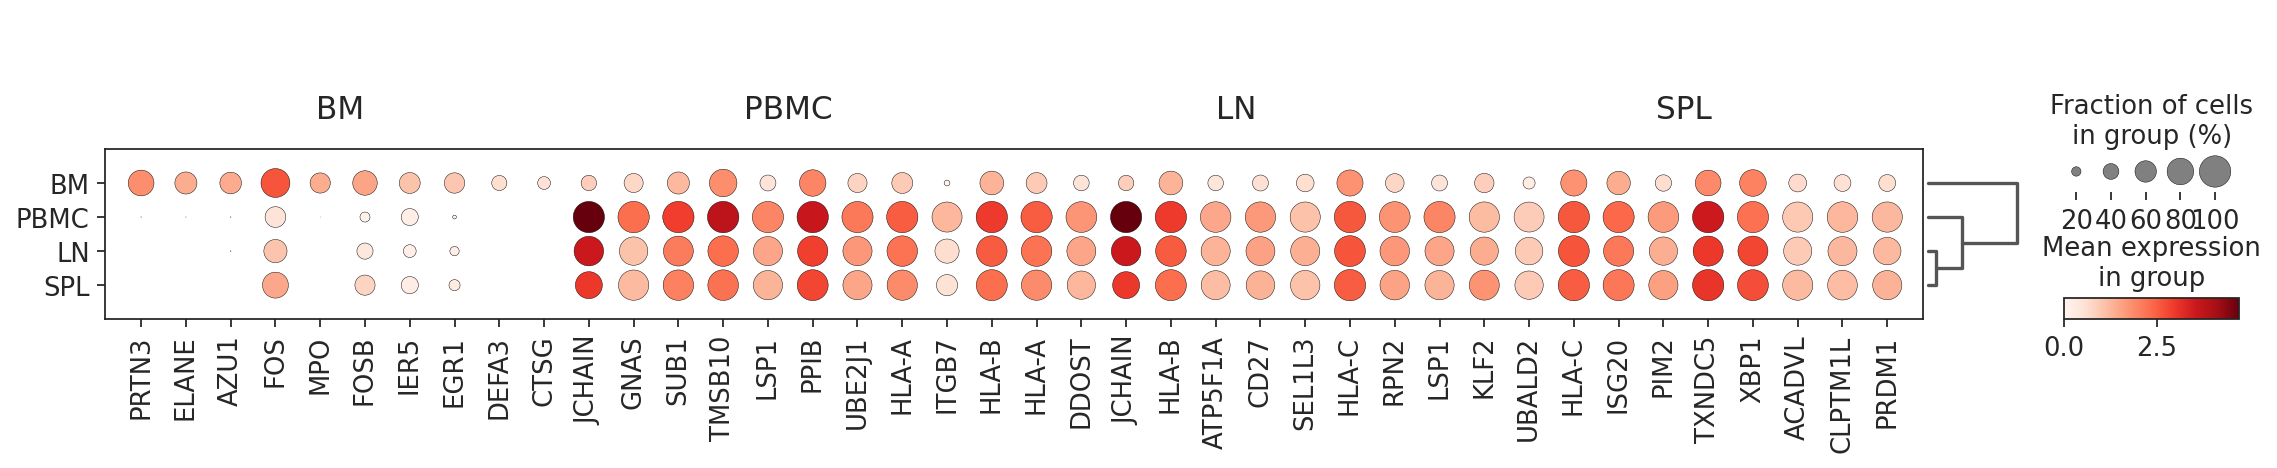

In [27]:
sc.pl.rank_genes_groups_dotplot(_sub_adata)

In [22]:
result = _sub_adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
gene_df = pd.DataFrame(
    {group + '_' + key[:]: result[key][group]
     # Get Each Clusters 10 top Genes
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

NameError: name '_sub_adata' is not defined

In [ ]:
holo_gene_set = []
num_genes = 20
result = _sub_adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
gene_df = pd.DataFrame(
    {group + '_' + key[:]: result[key][group]
     # Get Each Clusters 10 top Genes
    for group in groups for key in ['names', 'pvals']})

tissue_colors_dictionary = tissue_colors()
#iterate thru the unique tissues
for tis in _sub_adata.obs[label].unique():

    # reset rank genes df for new organ
    _gene_df = gene_df.copy()
     # Drop the filtered genes
    _gene_df = _gene_df[[tis + '_names', tis + '_pvals']].dropna()
    gene_list = _gene_df[tis + '_names'].to_list()
    genes = gene_list
    holo_gene_set.append(gene_list)
    score_name = tis + '_' + cell_type + "_residence_score"
    sc.tl.score_genes(_sub_adata, gene_list = gene_list[:num_genes], score_name = score_name, use_raw = False)
    plotdf = sc.get.obs_df(
            _sub_adata,
            keys=genes + [label, score_name])
    for gene in genes[:2]:
        g = sns.displot(data = plotdf, x = gene, hue = label, kind='ecdf', palette=tissue_colors_dictionary
                   )
        g.set_titles(cell_type)
        g.set_xlabels(gene + ' expression')
        directory = 'figures/{}_specific/{}_{}/'.format(label, cell_type, tis)
        if not os.path.exists(directory):
            os.makedirs(directory)
        g.savefig('figures/{}_specific/{}_{}/{}.pdf'.format(label, cell_type, tis, gene))
    g = sns.displot(data = plotdf, x=score_name, hue = label, kind = 'ecdf', palette=tissue_colors_dictionary )
    g.savefig('figures/{}_specific/{}.pdf'.format(label, score_name))

## Integrating the VeeDeeJays


In [31]:
df = pd.read_table('../shared_data/cell_calls_full/TBD6_called_cells_combined_vdjc_lineage_ids_vseq_germ_blast.tsv.gz')

In [32]:
# construct merge columns
adata.obs['cb_index']=adata.obs.index
adata.obs['cb'] = adata.obs['cb_index'].str.split('-', expand=True)[0]
adata.obs['cb_sample_id'] = adata.obs['cb'].astype(str) + '_' + adata.obs['tissue'].astype(str)
df['cb_sample_id'] = df['cb'] + '_' + df['sample_id']
# PBL vs PBMC
df['cb_sample_id'] = df['cb_sample_id'].str.replace('PBL', 'PBMC')

In [33]:
print(adata.obs.shape[0], "cells in GEX dataset")

58157 cells in GEX dataset


### Seems there's multiple vdj's per cb

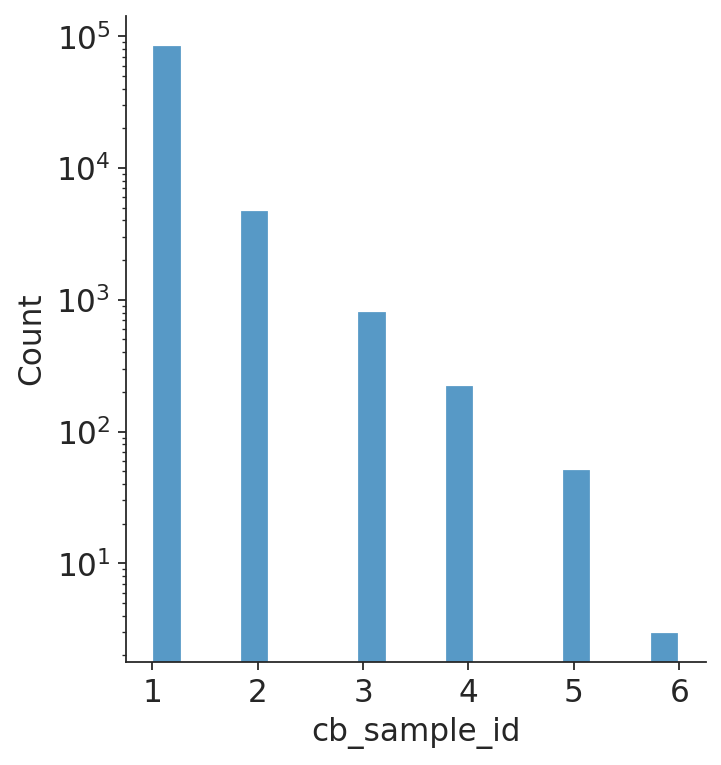

In [36]:
sns.displot(df.cb_sample_id.value_counts())
plt.yscale('log')

In [41]:
print(df.shape[0], "vdj / cbs")
print(df.drop_duplicates('cb_sample_id').shape[0], "single vdj with single cb")
print('dropping multiple vdj cbs')
df = df.drop_duplicates('cb_sample_id')
print('merging vdjs gex')
merged = pd.merge(adata.obs, df, left_on='cb_sample_id', right_on='cb_sample_id')
print(merged.shape[0], "cells after merging VDJs")

91863 vdj / cbs
91863 single vdj with single cb
dropping multiple vdj cbs
merging vdjs gex
31509 cells after merging VDJs


In [42]:
merged.set_index('cb_index', inplace=True)

In [43]:
# we lose  ~5% cells here but I'm not sure why yet
adata = adata[adata.obs.index.isin(merged.index)]
#merged = merged[merged.index.isin(adata.obs.index)]

In [44]:
adata.obs = merged

... storing 'cb_x' as categorical
... storing 'sample_id' as categorical
... storing 'cb_y' as categorical
... storing 'vdjc_info' as categorical
... storing 'vdj_sequence' as categorical
... storing 'c_call' as categorical
... storing 'locus' as categorical
... storing 'stop_codon' as categorical
... storing 'vj_in_frame' as categorical
... storing 'productive' as categorical
... storing 'v_call' as categorical
... storing 'd_call' as categorical
... storing 'j_call' as categorical
... storing 'sequence_alignment' as categorical
... storing 'germline_alignment' as categorical
... storing 'sequence_alignment_aa' as categorical
... storing 'germline_alignment_aa' as categorical
... storing 'v_sequence_alignment' as categorical
... storing 'v_sequence_alignment_aa' as categorical
... storing 'v_germline_alignment' as categorical
... storing 'v_germline_alignment_aa' as categorical
... storing 'd_sequence_alignment' as categorical
... storing 'd_sequence_alignment_aa' as categorical
... s

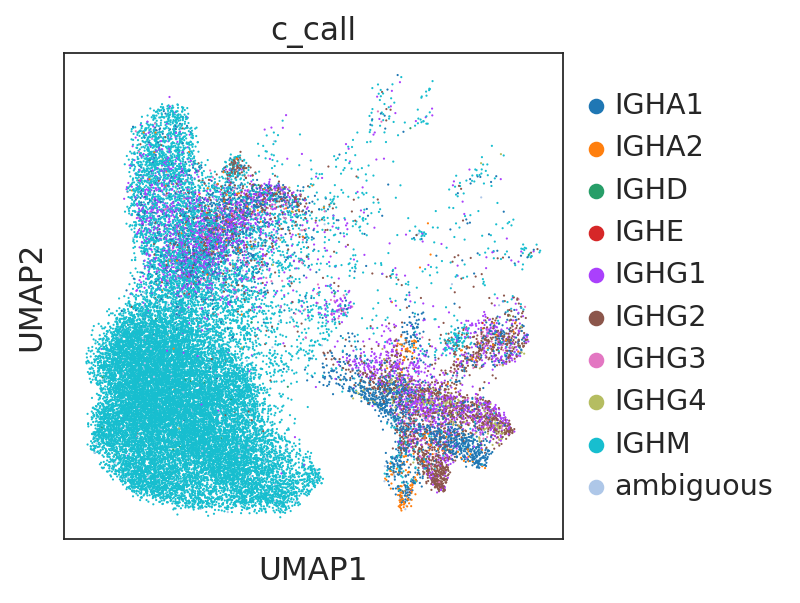

In [45]:
sc.pl.umap(adata, color = 'c_call')

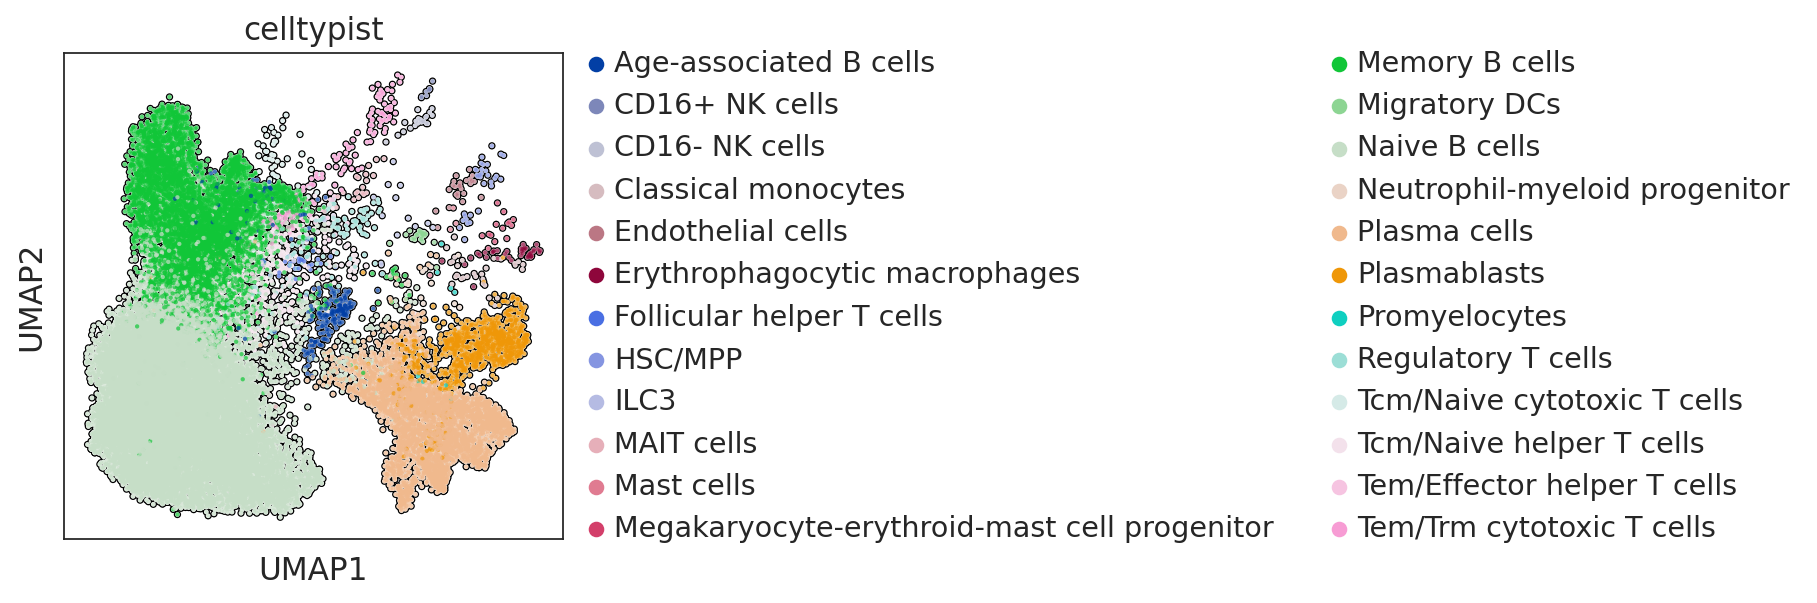

In [46]:
sc.pl.umap(adata, color = 'celltypist', size=15, add_outline=True)

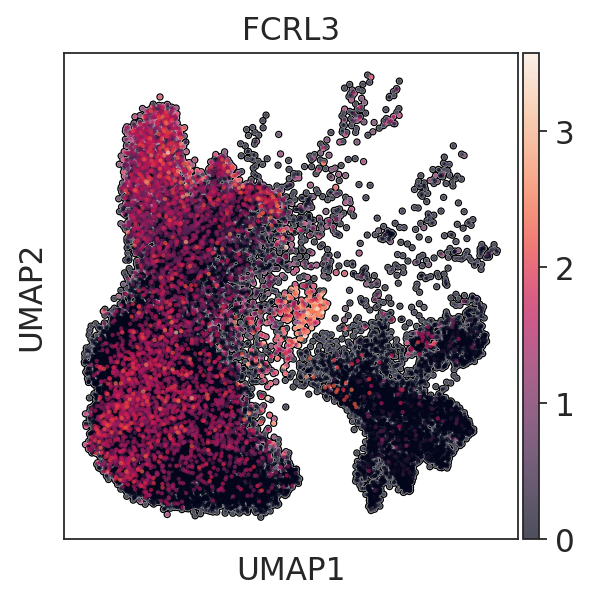

In [47]:
sc.pl.umap(adata, color = 'FCRL3', size=15, add_outline=True)

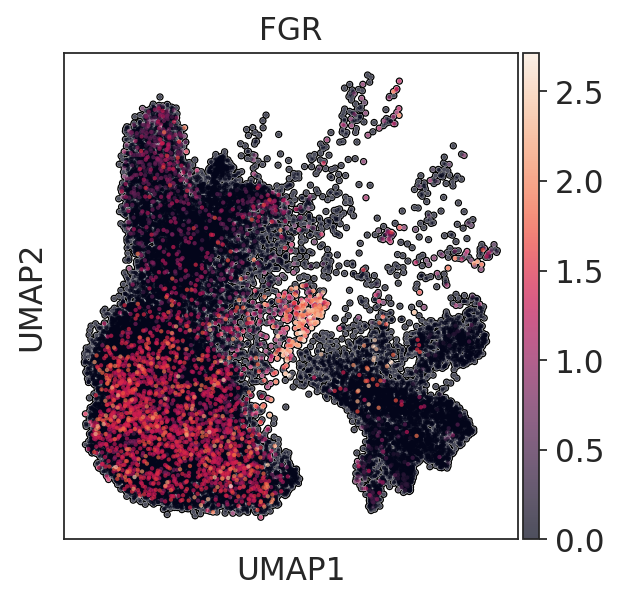

In [48]:
sc.pl.umap(adata, color = 'FGR', size=15, add_outline=True)

In [49]:
biglins = adata.obs.lineage_id.value_counts().index[:10]

In [50]:
_adata = adata[adata.obs.lineage_id.isin(biglins)]

In [51]:
_adata.obs.celltypist = _adata.obs.celltypist.cat.remove_unused_categories()

In [52]:
_adata.obs.groupby('lineage_id').sample_id.value_counts()

lineage_id     
2           BM     164
            LN      18
            SPL     12
            PBL      0
17          LN      32
            BM      21
            PBL     14
            SPL      6
84          BM      72
            LN       1
            PBL      1
            SPL      1
202         LN      57
            SPL      8
            BM       0
            PBL      0
271         BM      76
            LN       0
            PBL      0
            SPL      0
311         BM      60
            LN       0
            PBL      0
            SPL      0
2409        BM      60
            LN       0
            PBL      0
            SPL      0
3087        BM      61
            LN       0
            PBL      0
            SPL      0
4350        SPL    112
            BM       0
            LN       0
            PBL      0
6367        BM      96
            LN       0
            PBL      0
            SPL      0
Name: sample_id, dtype: int64

In [53]:
_adata.obs.groupby(['lineage_id', 'sample_id']).celltypist.value_counts()

lineage_id  sample_id                               
2           BM         Plasma cells                     155
                       Plasmablasts                       5
                       Classical monocytes                2
                       Naive B cells                      2
                       Erythrophagocytic macrophages      0
                                                       ... 
6367        BM         Promyelocytes                      0
                       Regulatory T cells                 0
                       Tcm/Naive cytotoxic T cells        0
                       Tcm/Naive helper T cells           0
                       Tem/Trm cytotoxic T cells          0
Name: celltypist, Length: 247, dtype: int64

In [54]:
adata.write_h5ad('data/vdj_TBD5.h5ad')

In [2]:
adata = sc.read_h5ad('../../data/processed_h5ad/vdj_TBD5.h5ad')

In [3]:
adata.obs.to_csv('../../data/vdj_gex_labels.tsv', sep='\t')